# STATS 199 
***
### Examining Similarity of Online Publications with K-Means Clustering and PCA


In [1]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas, datetime, re
import numpy as np
from nltk.stem.snowball import EnglishStemmer
from sklearn.preprocessing import scale

"""Attempts to load csv at `filename`, exits with non-zero status code if
fails. If optional `n_sample` argument is specified, randomly samples `n_sample`
rows and returns that DataFrame. Returns all rows by default.
"""
def load_dataset(filename, n_sample=None):
    try:
        df = pandas.read_csv(filename)
        if n_sample:
            df = df.sample(n_sample)
        return df
    except FileNotFoundError:
        print("File not found!")
        exit(1)
    except Exception as e:
        print(str(e))
        exit(2)

In [2]:
""" By default, returns a DataFrame with all articles after the given date. If the optional
keyword argument `before` is true, returns all articles before the given date. Defaults to the
date of the inauguration.
"""
def filter_since(year=2017, day=20, month=1, before=False, to_csv=False):
    filenames = ["article_data/articles1.csv",
                 "article_data/articles2.csv",
                 "article_data/articles3.csv"]
    
    df = pandas.DataFrame()
    for filename in filenames:
        df = df.append(pandas.read_csv(filename))

    dt = datetime.datetime(day=day, month=month, year=year)
    df['date'] = pandas.to_datetime(df['date'], yearfirst=True)
    
    if before:
        df = df.loc[df.date <= dt]
    else:
        df = df.loc[df.date > dt]
    
    if to_csv:
        if before:
            df.to_csv("before_{}_{}_{}.csv".format(day, month, year))
        else:
            df.to_csv("after_{}_{}_{}.csv".format(day, month, year))
    return df

In [29]:
stemmer = EnglishStemmer()

""" Compresses consecutive whitespace characters, tokenizes with whitespace 
as word break, and then stems each word. Returns joined words.
"""
def stem_words(sentence):
    sentence = re.sub("[\s]+", "", sentence)
    words = [stemmer.stem(word) for word in sentence.split(" ")]
    return " ".join(words)
    
def run_kmeans(filename, n_topics, ngram_range, n_components=2, **kwargs):
    stemmer = EnglishStemmer()
    data = load_dataset(filename)
    data.dropna(subset=['content', 'title'], inplace=True)
    vec = TfidfVectorizer(stop_words='english',
                          ngram_range=ngram_range,
                          max_features=1500)

    titles = data['title'].apply(lambda x: stem_words(re.sub("( - Breitbart)|([\s]+$)|(^[\s]+)|(as it happened)|(\u2019)|(\u2018)|(\u2013)|(\u201c)|(\u201d)|(\u00a0)|( - The New York Times)", " ", x)))
    transformed_docs = vec.fit_transform(titles)

    transformed_docs = transformed_docs
    scaled_docs = scale(transformed_docs, with_mean=False)
    topic_model = KMeans(n_clusters=n_topics)

    clusters = topic_model.fit_predict(scaled_docs)
    clusters_labels = [{'index': index.item(),
                        'cluster_label': cluster_label.item(),
                        'title': title,
                        'publication': publication} for index, cluster_label, title, publication in zip(np.arange(0, clusters.shape[0]), clusters, titles, data['publication'])]
    
    cluster_df = pandas.DataFrame(clusters_labels)
    cluster_df.to_csv("clusters.csv")
    components = get_pc(cluster_df,
                        n_topics=n_topics,
                        n_components = n_components,
                       **kwargs)
    
    return components


***
## Grouping Publications with Principal Component Analysis
Next, we decompose the publication by cluster column feature matrix with Principal Component Analysis. This is a form of dimensionality reduction, and finds the lower-dimensional (given by n_components) subspace with the greatest variance. This means that we can reduce the dimensonality to either 2D or 3D along the axes that have the greatest spread, and plot it.

In [37]:
# TODO: Does scaling the feature matrix affect the results?
""" Returns `n_components` coefficients of first `n_components` principal component
basis vectors of column space of publication by cluster label count matrix. That is,
each row is a different publication and each of the `n_topics` entries contains the
count of its articles titles in that cluster. 
"""

def get_pc(df, n_topics, n_components, return_model=False):

    publications = pandas.unique(df['publication'])
    init_matrix = np.zeros((publications.shape[0], n_topics))

    index_converter = {}
    for i,publication in enumerate(publications):
        index_converter[publication] = i

    for j in df.index:
        cluster = df.loc[j, 'cluster_label']
        init_matrix[index_converter[df.loc[j, 'publication']], cluster] += 1

    pca_model = PCA(n_components=n_components, svd_solver="randomized")
    
    components = pca_model.fit_transform(init_matrix)
    if return_model
    return components, publications

In [62]:
n_topics=50

matrix, publications = run_kmeans("article_data/full_articles.csv", 
                                  n_topics=n_topics,
                                  ngram_range=(1,3), 
                                  n_components=2)

daf = pandas.DataFrame(matrix, columns=['first', 'second'])  
daf.to_csv("k{}.csv".format(n_topics))

here1
here2
here3
(15,)
(15, 50)


In [59]:
import pandas, rpy2;
import rpy2.robjects.numpy2ri, rpy2.robjects.pandas2ri;
rpy2.robjects.numpy2ri.activate();
rpy2.robjects.pandas2ri.activate();
#rpy2.robjects.r['options'](warn=-1)
%load_ext rpy2.ipython



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [63]:
%R -i publications 
%R -i daf 

        first      second        publications
0  -0.2772785  0.03862549      New York Times
1   2.6003556 -2.16435646           Breitbart
2   0.3607369  2.17459346                 CNN
3  -0.5763128 -0.53047409    Business Insider
4  -0.4421355  0.30756842            Atlantic
5  -0.9719103 -0.25619331            Fox News
6  -0.8271802 -0.80911493 Talking Points Memo
7  -0.8905442 -0.20499369       Buzzfeed News
8  -0.5791328 -0.42987958     National Review
9   1.5893368  1.65024675       New York Post
10 -0.1610885  0.11846672            Guardian
11  0.5108840  0.42036951                 NPR
12  0.2573916  0.26398706             Reuters
13 -0.8844066 -0.52480660                 Vox
14  0.2912844 -0.05403875     Washington Post


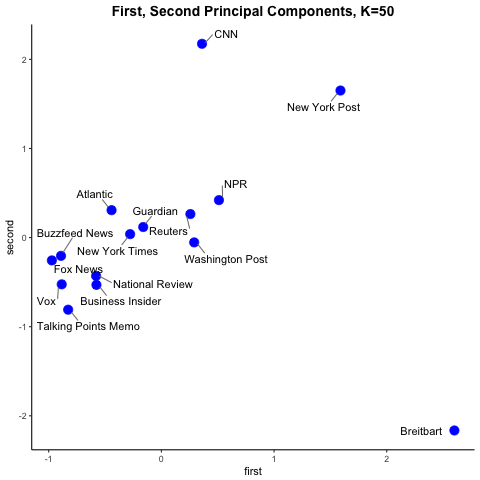

In [65]:
%%R library(ggplot2); library(dplyr); library(ggrepel); library(plotly);
daf$publications = publications
print(daf)


graph = daf %>% ggplot() + aes(x=first, y=second) + geom_point(size=4, shape=19, color="blue") + geom_text_repel(aes(label=publications),box.padding   = 0.35, 
                  point.padding = 0.5,
                  segment.color = 'grey50') + theme_classic() + ggtitle('First, Second Principal Components, K=50') + theme(plot.title=element_text(hjust=0.5,
                                                                                                                                                   size=14,
                                                                                                                                                   face="bold")) + ggsave("k50.png")


print(graph)

#plot_ly(daf, x=~first, y=~second, z=~third, text= ~ as.factor(publications)) %>% add_markers()